In [1]:
## opencv 설치
!pip install opencv-python 

In [13]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 128, 128), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=2, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

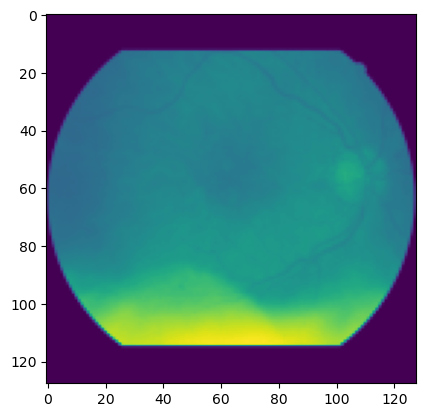

(642, 1, 128, 128)
train loss:11.12148538276493
=== epoch:1, train acc:0.2757009345794392, test acc:0.2908496732026144 ===
train loss:2.001598369705519
train loss:3.5980880634301298
train loss:1.4490077747553634
train loss:0.6500549873968677
train loss:0.6335304811803812
train loss:0.6651524448623534
train loss:0.6640219129713658
train loss:0.6629344525010323
train loss:0.6300782326483323
train loss:0.6111976092673583
train loss:0.6522781229656661
train loss:0.643654757954059
train loss:0.6151668076893515
train loss:0.617272080973463
train loss:0.641455215409427
train loss:0.5969058448309743
train loss:0.5876671197001417
train loss:0.48384213019798245
train loss:0.6634281558776522
train loss:0.6299340129018358
train loss:0.6468969483506746
train loss:0.5550754208758356
train loss:0.6740541282154191
train loss:0.6198984988559129
train loss:0.5993920283897656
train loss:0.5901112070818962
train loss:0.6173214491720828
train loss:0.656914885526401
train loss:0.5818689161063442
train loss:

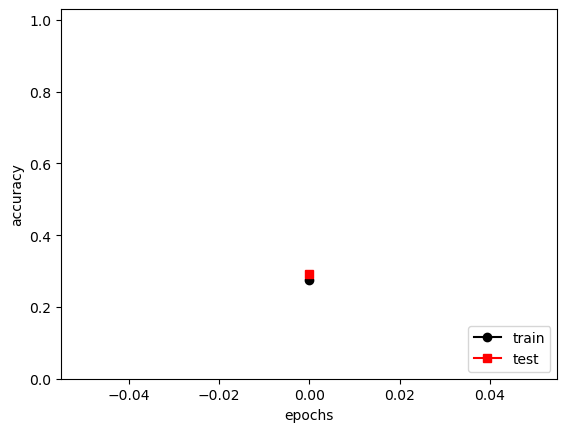

In [17]:
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from dataset.mnist import load_mnist
from common.trainer import Trainer

normal_dir = os.path.join('.', 'Normal_images')
glaucoma_dir = os.path.join('.','Glaucoma_images')

normal_files = glob.glob(normal_dir+'/*.jpg')
glaucoma_files = glob.glob(glaucoma_dir+'/*.jpg')

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': normal_files + glaucoma_files,
    'label': [1] * len(glaucoma_files) + [0] * len(normal_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels =  train_test_split(files_df['filename'].values,
                                                                       files_df['label'].values,
                                                                       test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, test_size=0.1, random_state=42)

#print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

import cv2

def make_data(filenames):
    data_map = []
    for imgfname in filenames:
        img = cv2.imread(imgfname)
        img = cv2.resize(img, (128,128), interpolation=cv2.INTER_AREA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = np.expand_dims(img, axis = -1)
        data_map.append(img)        
    return np.array(data_map)

train_data = make_data(train_files)
val_data = make_data(val_files)
test_data = make_data(test_files)

imgplot = plt.imshow(test_data[10])
plt.show()

train_data = train_data.transpose(0,3,1,2)
test_data = test_data.transpose(0,3,1,2)
print(train_data.shape)

max_epochs = 20

network = SimpleConvNet(input_dim=(1,128,128), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=2, weight_init_std=0.01)
                        
trainer = Trainer(network, train_data, train_labels, test_data, test_labels,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
#network.save_params("params.pkl")
#print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
#x = np.arange(max_epochs)
x = np.arange(len(trainer.train_acc_list))
plt.plot(x, trainer.train_acc_list, color='k', marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, color='r', marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.03)
plt.legend(loc='lower right')
plt.show()